# The Sower


Requirements:

- "data/interim/sower.csv"

# EDA

The dataset is basically a times series. The data comes from different channels (Amazon, Apple, Barnes and Noble) and it is not normalized.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;
sns.set(rc={'figure.figsize':(10,8)})
sns.set(style="whitegrid")

from bokeh.io import show, output_notebook
from bokeh.palettes import Spectral

output_notebook()

Loading BokehJS ...

In [2]:
df = pd.read_csv("../data/interim/sower.csv")
df.head()

,entity,formattype,todate,amazontotalreviews,minappleprice,amazontotalrevenue,accruedpreordersoldunits,amazonlumpedpreordersubscriptionrevenue,preordersalesrevenue,foundatamazon,...,accruedpreordersalesrevenue,maxbarnesandnobleprice,preorderrevenue,pubtrackreported,lumpedpreorderrevenue,amazonsoldunits,amazonpreordersubscriptionrevenue,preordersubscriptionunits,amazonpreordersalesrevenue,maxappleprice
0,Alone in the dark,audio,2017-04-08,306.0,0,2990,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,Alone in the dark,audio,2017-04-09,306.0,0,2990,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
2,Alone in the dark,audio,2017-04-22,306.0,0,6580,0,0,0,1,...,0,0,0,1,0,2,0,0,0,0
3,Alone in the dark,audio,2017-04-23,306.0,0,6580,0,0,0,1,...,0,0,0,1,0,2,0,0,0,0
4,Alone in the dark,audio,2017-04-27,307.0,0,4785,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0


In [3]:
df["todate"] = pd.to_datetime(df["todate"])

Let's take a closer on what we've got,

## Channels

It looks like we have equivalent variables for different sellers/channels , e.g "soldunits", "amazonsoldunits" and "applesoldunits",

In [4]:
CHANNELS = [
    "amazon",
    "apple",
    "barnesandnoble",
]

Let'do totals, ignoring for now the CHANNELS. I manually check some examples, and it looks reasonable. If can always can back.

In [5]:
df_plot = df.loc[:, ~df.columns.str.contains("|".join(CHANNELS), regex=True)] 

# variable with a channel
#df_channels = df.filter(regex="|".join(CHANNELS), axis=1)
#df_channels.head()

#import re
#normalize = lambda x: re.sub(r"|".join(CHANNELS), "", x)

Let's unpivot 

In [6]:
df_plot = df_plot.melt(id_vars=["entity", "formattype", "todate"], var_name="variable", value_name="value")

# Plot

Let's plot all data, so we will have a better picture,

In [7]:
from bokeh.plotting import figure
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, Select, TextInput, HoverTool

BOOKS = sorted(df_plot['entity'].unique())
TYPES = sorted(df_plot['formattype'].unique())
VARIABLES = sorted(df_plot['variable'].unique())
    
def update_data(*args, **kwargs):
    query = ' & '.join([f'{k}=="{v}"' for k, v in kwargs.items()])
    qs = df_plot.query(query)
    return dict(x=qs["todate"].values, y=qs["value"].values)
    
def modify_doc(doc):
    
    p = figure(title="Sower: Interactive Plot",
                x_axis_label="Date",
                y_axis_label="Value",
                x_axis_type='datetime', 
                width=1000)
    
    p.add_tools(HoverTool(
        tooltips=[
            ('(x, y)', "(@x{%F}, @y)"),],
        formatters={
            '@x': 'datetime'}))
    
    # data
    source = ColumnDataSource(
                data=update_data(entity="The Walking Dead", formattype="print", variable="soldunits"))
        
    p.scatter(x='x', y='y', source=source, color="purple", alpha=0.5)
    
    # filters
    select = Select(title="Book", value="The Walking Dead", options=BOOKS)
    select2 = Select(title="Type", value="print", options=TYPES)
    select3 = Select(title="Variable", value="soldunits", options=VARIABLES)

    def update_points(attrname, old, new):
        source.data = update_data(entity=select.value, formattype=select2.value, variable=select3.value)
    select.on_change('value', update_points)
    select2.on_change('value', update_points)
    select3.on_change('value', update_points)

    layout = column(row(select, select2, select3, width=800), row(p))

    doc.add_root(layout)

show(modify_doc)

# Notes

That is a starting point. Let's put some notes down,

- **We should validate:**

    - For instance, filtering `The Walking Dead > print > accruedpreordersoldunits`, we clearly see a growth in the number of preorders ahead of the data of publication (2017-08-29). That is a good indication that our aggregations hold true.
    
    - However, we should validate the data quality and our assumptions with stakeholders
    
- **Most fields *are not* telling us a story:**
    
     - We could not extract any information from most of the fields, either because sparsity or because the number does not describe what we are after.  
    
    
- *Most fields *are not* independent:*

    Just think of `soldunits` and `salesrevenue`. Both differ basically by a factor and they are describing the same underlying quantity.
    
Let's check,

## The Walking Dead

In [8]:
df = df[df["entity"] == "The Walking Dead"]

In [9]:
COLUMNS = [
    "soldunits",
    "salesrevenue",
    "amazonsoldunits",
    "totalunits",
    
]

wdf = df.set_index(["entity", "formattype", "todate"])[COLUMNS]
wdf.corr()

,soldunits,salesrevenue,amazonsoldunits,totalunits
soldunits,1.000000,0.963613,0.950199,0.990727
salesrevenue,0.963613,1.000000,0.892756,0.968671
amazonsoldunits,0.950199,0.892756,1.000000,0.942097
totalunits,0.990727,0.968671,0.942097,1.000000


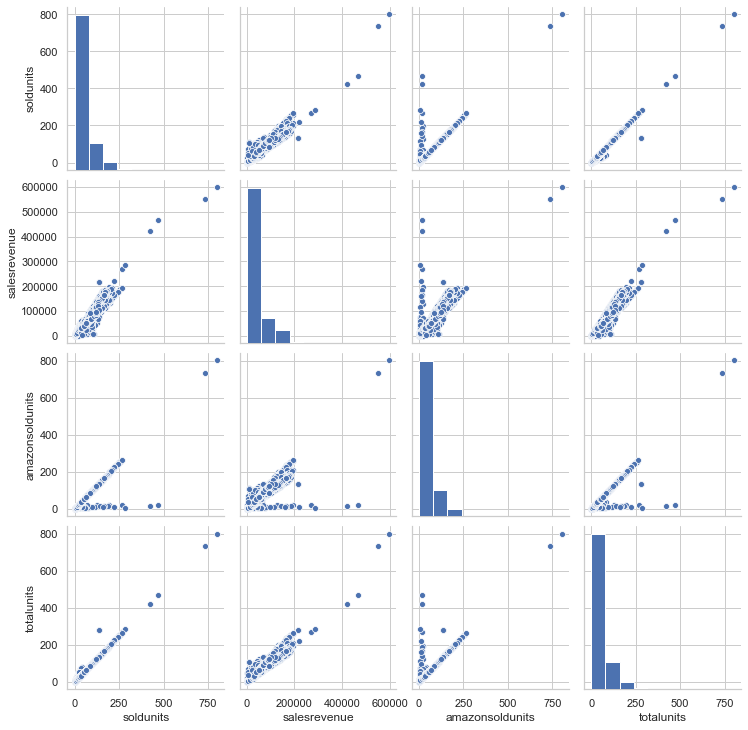

In [10]:
sns.pairplot(wdf)

All those variables are highly correlated. Actually, they represent the *same information*

In [11]:
all(df["soldunits"] == df["amazonsoldunits"] + df["applesoldunits"] + df["barnesandnoblesoldunits"])

True

Note that we added `amazonsoldunits` in the comparison. In matter of fact, Amazon represents more than 90% of sales,

In [12]:
f'{100*(df["amazonsoldunits"]/df["soldunits"]).mean():.02f}% of sold units from Amazon'

'93.23% of sold units from Amazon'

So that brings us down to 2 variables basically,

- `soldunits`
- `subscriptionsunit`

In [13]:
all(df["totalunits"] == df["soldunits"] + df["subscriptionunits"])

True

Let's the distribution for those variables, 

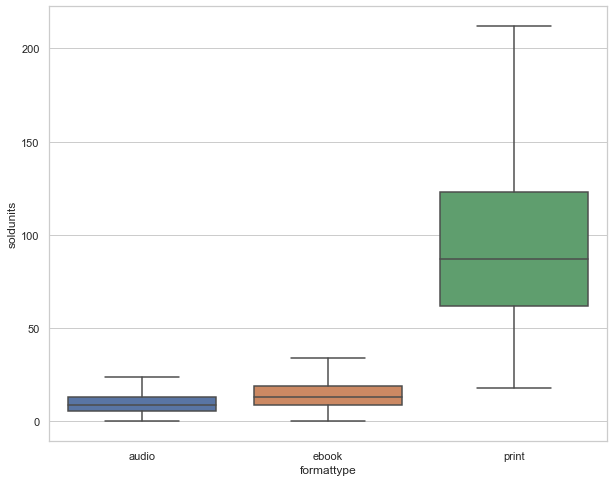

In [14]:
sns.boxplot(x="formattype", y="soldunits", data=df, showfliers=False)

Looking at the distributions, a bad day for print still has a strong position compared to audio and ebook,

In [15]:
df[["formattype", "soldunits"]].describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
formattype,2582,3,ebook,874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
soldunits,2582,NaN,NaN,NaN,42.7316,55.2147,0,9,16,63,801


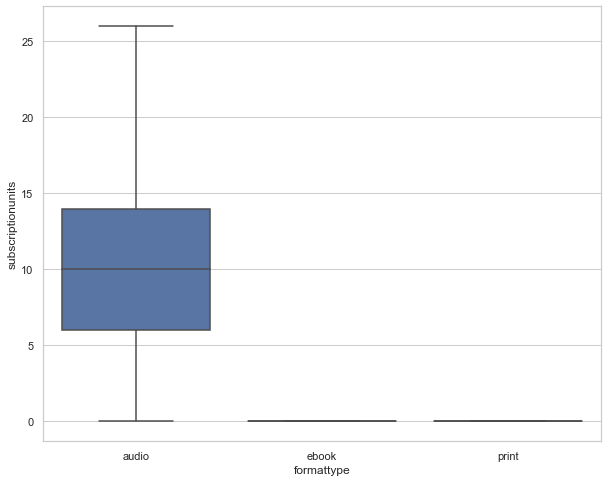

In [16]:
sns.boxplot(x="formattype", y="subscriptionunits", data=df, showfliers=False)

All subscriptions exclusively for audio, 

### Let's take a look at different formats,

In [17]:
wdf = df.pivot_table("totalunits", ["todate"], "formattype")

In [18]:
p = figure(title="Sower: Which format is the most sold? (The Walking Dead)", 
            x_axis_label="Date",
            y_axis_label="Units",
            x_axis_type='datetime')

p.varea_stack(stackers=list(wdf.columns), x="todate", color=Spectral[3], legend_label=list(wdf.columns), source=wdf.reset_index())

# reverse the legend entries to match the stacked order
p.legend.items.reverse()

show(p)